###**ATOC4500 Data Science Lab: Final Project**
###**Seasonal Variability Across Colorado**
###Authors: Syndey Crandall (sycr6025@colorado.edu) , Alyssa Ripley  (alri6419@colorado.edu)###
###Last updated: May 2, 2022###

**>>>> This code is available on github at https://github.com/scrand23/ATOC4500_Crandall_Ripley_FinalProject**

**>>>> NOTE: Please run this and other notebooks using a Chrome browser**

###**Introduction** 
The seasonality of a given location can be determined by several factors, including topography, latitude, proximity to a major water source, and the typical upper-atmospheric flow. While seasonality is quite varied based on these variables, the more traditional seasonal definition splits a year into 4 groups based on the calendar month. These divisions are known as the meteorological seasons, and they oftentimes don't accurately communicate the climate of a given location at a given time of year.   

In this project we focused on how seasonality across Colorado is altered by topography, and whether topography affects the number of true seasons experienced at a given location. We hypothesize that regions with similar elevation and distance from large topography will have similar seasonality, and that locations further from major topography will be best represented by a 2 season model. Locations close to major topography will be best represented by a 3 season model.

Four locations were selected to form a zonal cross section of the state. These cities were: Boulder$_1$, Eagle$_2$, Grand Junction$_3$, and Limon$_4$, CO. Hourly data from the airport at each location was used in this project. The variables included in these datasets were air temperature (℉), dew point temperature (℉), precipitation (inches), relative humidity (%), station pressure (mb), wind direction (°), wind speed (mph), and wind gust speed (mph). The datasets included observations from January 1st, 2012 at 00:00 to December 31st, 2021 at roughly 23:00 local time.

###**Step 1: Read in data**



4 data sets from Limon, Boulder, Eagle, and Grand Junction. Our data spans from Jan. 1st 2012 through Dec. 31st 2021. We have access to air temperature (℉), dew point temperature (℉), precipitation (inches), relative humidity (%), station pressure (mb), wind direction (°), wind speed (mph), and wind gust speed (mph) as variables. We used the variables air temperature, relative humidity, and wind speed for cluster modeling. Our data has been preprocessed and missing data was filled in with the mean value of that variable. A column was added to each dataset with the season each measurement traditionally belongs to.


In [ ]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.cluster.vq import vq, kmeans, whiten
import datetime as dt

In [ ]:
## add code cells here to read in your data

# read in data
limonDF = pd.read_csv("https://raw.githubusercontent.com/scrand23/ATOC4500-DataScience/main/Limon_2012-2021_hourlydata_munged.csv")
grandJunctionOrigDF = pd.read_csv("https://raw.githubusercontent.com/scrand23/ATOC4500-DataScience/main/72476023066_GrandJunction_2002-2021_hourlydata_munged.csv")
boulderDF = pd.read_csv("https://raw.githubusercontent.com/scrand23/ATOC4500-DataScience/main/72053300160_Boulder_2012-2021_hourlydata_munged.csv")
eagleDF = pd.read_csv("https://raw.githubusercontent.com/scrand23/ATOC4500-DataScience/main/72467523063_Eagle_2012-2021_hourlydata_munged.csv")

###**Step 2: Munge data**

Each of the four datasets used in this project had missing values. These values were replaced with the average value of the variable that had missing data, and was done outside of this notebook.

The datasets used in this project did not have the exact same number of observations, but the Grand Junction and Boulder datasets each had substantially more datapoints than the Limon and Eagle sets. The Grand Junction dataset began on January 1st, 2002, whereas the other sets started on January 1st, 2012. Hense, the portion of the Grand Junction dataset from before January 1st, 2002 was removed from the dataframe used in this project. The dataset from Boulder had observations recorded appriximately every 20 minutes, while the other sets were between every 40 minutes to every hour. The Boulder dataset was shortened to be approximately the same length as the other 3 locations by only using observations taken in the first half hour of each hour.

  New columns were also added to each dataset. These columns were:
- a datetime object
- hour
- minute
- season

The datetime column was used to determine which season each datapoint would be classified into. Each observation was classified into a season based on the month the observation was taken in, and whether that month fell into meteorological winter, spring, summer or fall. The seasons were given an identification number, winter 1, spring 2, summer 3, fall 4, that was stored in the season column of each dataframe.


The minute column, derived from the datetime object column, was used to shorten the Boulder dataset.


The hour column was used to select only noon observations (hour = 12) in each dataset for k-means clustering. This column was also derived from the datetime object. 

In [ ]:
## add code cells here to process your data to prepare it for the data science method, i.e. "munge" it

### the Grand Junction dataframe starts at an earlier date than the other 3 (2002 vs. 2012)
### adjust grandJunctionDF to only include the values we need (match up with the other datasets)

# find the row number closest to the start of the other datasets
grandJunctionOrigDF.loc[128691] # this is the closest to the start of the other datasets
 
# create a new dataframe for new time period ( from the closest to the start of the other datasets to the end)
grandJunctionDF = grandJunctionOrigDF[128692:]
grandJunctionDF.index = range(len(grandJunctionDF)) # adjust the row indices to start at 0

In [ ]:
# add columns for day, month, year, hour, and minute
limonDF["Date time"] = pd.to_datetime(limonDF["datetime"])
limonDF["year"] = limonDF["Date time"].dt.year
limonDF["month"] = limonDF['Date time'].dt.month
limonDF["day"] = limonDF['Date time'].dt.day
limonDF["hour"] = limonDF["Date time"].dt.hour

boulderDF["Date time"] = pd.to_datetime(boulderDF["datetime"])
boulderDF["hour"] = boulderDF["Date time"].dt.hour
boulderDF["minute"] = boulderDF['Date time'].dt.minute

eagleDF["Date time"] = pd.to_datetime(eagleDF["datetime"])
eagleDF["year"] = eagleDF["Date time"].dt.year
eagleDF['month'] = eagleDF['Date time'].dt.month
eagleDF["day"] = eagleDF['Date time'].dt.day
eagleDF['hour'] = eagleDF['Date time'].dt.hour

grandJunctionDF["Date time"] = pd.to_datetime(grandJunctionDF["datetime"])
grandJunctionDF["year"] = grandJunctionDF["Date time"].dt.year
grandJunctionDF["month"] = grandJunctionDF['Date time'].dt.month
grandJunctionDF["day"] = grandJunctionDF['Date time'].dt.day
grandJunctionDF['hour'] = grandJunctionDF["Date time"].dt.hour

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
# boulderDF is significantly longer than the others
# only use data recorded in the first half hour of every hour
boulderMungedDF = boulderDF.query("minute < 30")
boulderMungedDF = boulderMungedDF.reset_index()
boulderDF = boulderMungedDF

In [ ]:
# add columns for season
# from Homework 4
seasons = {(1, 12, 2): 1, (3, 4, 5): 2, (6, 7, 8): 3, (9, 10, 11): 4}

# function for relating season to month
def season(ser):
    for k in seasons.keys():
        if ser in k:
            return seasons[k] 
        
limonDF['season']= [season(month) for month in pd.DatetimeIndex(limonDF['datetime']).month]
boulderDF['season']=[season(month) for month in pd.DatetimeIndex(boulderDF['datetime']).month]
eagleDF['season']=[season(month) for month in pd.DatetimeIndex(eagleDF['datetime']).month]
grandJunctionDF['season']=[season(month) for month in pd.DatetimeIndex(grandJunctionDF['datetime']).month]

# check one of the datasets to make sure it worked
# limonDF.query("season == 2")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
# graph timeseries subplots of temperature for the first 10 datapoint at all locations 
# this can be used to show that we looked at our data

# fig, ax = plt.subplots(4, figsize = (10,8))
# fig.suptitle("Timeseries of air temperature from each location")
# fig.text(0.5, 0.04, 'Date', ha='center', va='center')
# fig.text(0.06, 0.5, 'Temperature ($^\circ$C)', ha='center', va='center', rotation='vertical')

# fig.autofmt_xdate()

# # subplot 1: Limon
# ax[0].plot(limonDF["Date time"],limonDF["drytemp_F"])
# ax[0].set_title("Limon, CO")

# # subplot 2: Boulder
# ax[1].plot(boulderDF["Date time"], boulderDF["drytemp_F"])
# ax[1].set_title("Boulder, CO")

# # subplot 3: Eagle
# ax[2].plot(eagleDF["Date time"], eagleDF["drytemp_F"])
# ax[2].set_title("Eagle, CO")

# # subplot 4: Grand Junction
# ax[3].plot(grandJunctionDF["Date time"], grandJunctionDF["drytemp_F"])
# ax[3].set_title("Grand Junction, CO")

###**Step 3: Apply Data Science Method(s)**

The datasets will be used to model k-means clustering. Each locations munged dataset is scaled in order to be used for the cluster modeling. From the scaled dataset, three centroids are created, one 2 clusters, one for 3 clusters, and one for 4 clusters. The traditional four seasons are also defined within each dataset. 




In [ ]:
# Universal Variables
included_cols = ["drytemp_F", 'dewtemp_F', 'prec_inch', 'RH', 'pres_mbar', 'wdir', 'wspd_mph','wgust_mph']
FOUR_CLUSTERS = 4
THREE_CLUSTERS = 3
TWO_CLUSTERS = 2
hour = 12
cluster_label_list = ["Cluster 1", "Cluster 2", "Cluster 3", "Cluster 4"]

In [ ]:
# select time function
def select_time(df, hour):
    selectdf = df[df.hour==hour]
    return(selectdf)

In [ ]:
def scale_and_convert_to_numpy(selectdf, included_cols):
    data = selectdf.loc[:, selectdf.columns.isin(list(included_cols))].to_numpy()
    scaled_data = whiten(data)
    return data, scaled_data # need to also return data

In [ ]:
def cluster_data(NO_CLUSTERS, scaled_data):
    centroids, _  = kmeans(scaled_data,NO_CLUSTERS,iter=20)
    idx, _ = vq(scaled_data,centroids)
    idx=idx+1
    return centroids, idx # need to also return centroids

In [ ]:
def season_clustered(season_idx, seasonNum, idx, hour):
    ## find all of the days in the specified season, i.e., where season_idx= seasonNum
    seasonIdx=np.nonzero(np.where(season_idx==seasonNum,1,0))
    season=idx[seasonIdx]
    return season

In [ ]:
# Limon Clustering
limonClusterDF = select_time(limonDF, hour)
limonData, limonScaledData = scale_and_convert_to_numpy(limonClusterDF, included_cols)
limonCentroids4, limonIdx4 = cluster_data(FOUR_CLUSTERS, limonScaledData)
limonCentroids3, limonIdx3 = cluster_data(THREE_CLUSTERS, limonScaledData)
limonCentroids2, limonIdx2 = cluster_data(TWO_CLUSTERS, limonScaledData)

limonSeasonIdx=limonDF['season'][limonDF.hour==hour].to_numpy()

winter = season_clustered(limonSeasonIdx, 1, limonIdx4, hour)
spring = season_clustered(limonSeasonIdx,2, limonIdx4, hour)
summer = season_clustered(limonSeasonIdx, 3, limonIdx4, hour)
fall = season_clustered(limonSeasonIdx, 4, limonIdx4, hour)

In [ ]:
# Boulder Clustering
boulderClusterDF = select_time(boulderDF, hour)
boulderData, boulderScaledData = scale_and_convert_to_numpy(boulderClusterDF, included_cols)
boulderCentroids4, boulderIdx4 = cluster_data(FOUR_CLUSTERS, boulderScaledData)
boulderCentroids3, boulderIdx3 = cluster_data(THREE_CLUSTERS, boulderScaledData)
boulderCentroids2, boulderIdx2 = cluster_data(TWO_CLUSTERS, boulderScaledData)

boulderSeasonIdx=boulderDF['season'][boulderDF.hour==hour].to_numpy()

winter = season_clustered(boulderSeasonIdx, 1, boulderIdx4, hour)
spring = season_clustered(boulderSeasonIdx,2, boulderIdx4, hour)
summer = season_clustered(boulderSeasonIdx, 3, boulderIdx4, hour)
fall = season_clustered(boulderSeasonIdx, 4, boulderIdx4, hour)

In [ ]:
# Eagle Clustering
eagleClusterDF = select_time(eagleDF,hour)
eagleData, eagleScaledData = scale_and_convert_to_numpy(eagleClusterDF, included_cols)
eagleCentroids4, eagleIdx4 = cluster_data(FOUR_CLUSTERS, eagleScaledData)
eagleCentroids3, eagleIdx3 = cluster_data(THREE_CLUSTERS, eagleScaledData)
eagleCentroid2, eagleIdx2 = cluster_data(TWO_CLUSTERS, eagleScaledData)

eagleSeasonIdx=eagleDF['season'][eagleDF.hour==hour].to_numpy()

winter = season_clustered(eagleSeasonIdx, 1, eagleIdx4, hour)
spring = season_clustered(eagleSeasonIdx, 2, eagleIdx4, hour)
summer = season_clustered(eagleSeasonIdx, 3, eagleIdx4, hour)
fall = season_clustered(eagleSeasonIdx, 4, eagleIdx4, hour)

In [ ]:
# Grand Junction Clustering
grandJunctionClusterDF = select_time(grandJunctionDF, hour)
grandJunctionData, grandJunctionScaledData = scale_and_convert_to_numpy(grandJunctionClusterDF,included_cols)
grandJunctionCentroids4, grandJunctionIdx4 = cluster_data(FOUR_CLUSTERS, grandJunctionScaledData)
grandJunctionCentroids3, grandJunctionIdx3 = cluster_data(THREE_CLUSTERS, grandJunctionScaledData)
grandJunctionCentroids2, grandJunctionIdx2 = cluster_data(TWO_CLUSTERS, grandJunctionScaledData)

grandJunctionSeasonIdx=grandJunctionDF['season'][grandJunctionDF.hour==hour].to_numpy()

winter = season_clustered(grandJunctionSeasonIdx, 1, grandJunctionIdx4, hour)
spring = season_clustered(grandJunctionSeasonIdx, 2, grandJunctionIdx4, hour)
summer = season_clustered(grandJunctionSeasonIdx, 3, grandJunctionIdx4, hour)
fall = season_clustered(grandJunctionSeasonIdx, 4, grandJunctionIdx4, hour)

###**Step 4: Present results visually using 2-3 graphs**

In [ ]:
def seasonal_assignment_by_year(city, cluster_label_list, NO_CLUSTERS, selectdf, idx):
    ### find the julian day and year for each point in the dataset

  fool=selectdf['datetime'].values
  
  jday = [int(dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S').strftime('%j')) for date in fool]
  #print(jday)
  year = [int(dt.datetime.strptime(date, '%Y-%m-%d %H:%M:%S').strftime('%Y')) for date in fool]
  #print(year)

  ### find the minimum and maximum index of the array for each year
  idx_min=[]
  idx_max=[]
  for yearSEL in np.arange(2012,2022,1):
    #print(yearSEL)
    yearidx=[index for index,value in enumerate(year) if value==yearSEL]
    idx_min.append(min(yearidx))
    idx_max.append(max(yearidx))

  ### plot all years
  plt.figure(figsize = (10,6))

  for y in np.arange(0,10,1):
    plt.plot(jday[np.min(idx_min[y]):np.max(idx_max[y])],idx[np.min(idx_min[y]):np.max(idx_max[y])]+0.08*y,'.',label=str(y+2012))

  plt.xlabel('Day of the year');
  plt.legend(bbox_to_anchor=(1, 0.75), loc='upper left', ncol=1);
  plt.yticks(np.arange(1.25,NO_CLUSTERS+1.25),labels=cluster_label_list)
  plt.title("Seasonal cycle of cluster assignment by year for "+city)

In [ ]:
def variable_scatter_plots(scaled_data, var1, var2, included_cols, NO_CLUSTERS, idx, centroids, data):
    vars2plot = [var1,var2]
    data2plot = [data[:,included_cols.index(var)] for var in vars2plot]

    ## find the integer index of the variable to plot
    varidx2plot=np.zeros(2,dtype="int")
    for i in np.arange(0,2):
      #print(vars2plot[i])
      varidx2plot[i]=included_cols.index(vars2plot[i])
    #print(varidx2plot)

    ### Next plot these variables as the original valueswith colors to identify the associated cluster
    # (red=1, blue=2, grey=3, orange=4)
    cols = ['','red','blue','grey','orange']
    plt.figure(figsize=(8,5))
    plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
    for (ind,val) in enumerate(np.transpose(data2plot)):
        plt.plot(val[0],val[1],".", color=cols[idx[ind]], markersize=10, markerfacecolor = 'none')
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel(vars2plot[0],fontsize=18);
    plt.ylabel(vars2plot[1],fontsize=18);
    plt.show()

    ### You can also plot these variables as scaled values with the cluster centers
    plt.figure(figsize=(8,5))
    plt.title('K-means classification with ' + str(NO_CLUSTERS) + ' Clusters',fontsize=22)
    plt.scatter(scaled_data[:, varidx2plot[0]], scaled_data[:, varidx2plot[1]])
    plt.scatter(centroids[:, varidx2plot[0]], centroids[:, varidx2plot[1]],color='red',marker='*',s=1000)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel('scaled '+vars2plot[0],fontsize=18);
    plt.ylabel('scaled '+vars2plot[1],fontsize=18);
    plt.show()

In [ ]:
# season model vs meteorological seasons number of days assigned
def hist_type_1(idx, season_idx, NO_CLUSTERS, cluster_label_list):
    delta= 1                               ## bin size
    minbin= 0.5                             ## minimum bin value
    maxbin= 5.5                              ## maximum bin value
    hist_bins = np.arange(minbin,maxbin,delta) ## bins
    #print(hist_bins) ## print your histograms to check them

    #### all data - plot the histogram
    h, mids = np.histogram(idx,bins=hist_bins);
    plt.hist(idx,bins=mids,facecolor='white',edgecolor="grey",label='k-means',lw=2);
    plt.hist(season_idx,bins=mids,facecolor='r',edgecolor="r",label='actual seasons',alpha=0.5,lw=2);
    plt.ylabel('count')
    #plt.ylim(0,1000)
    plt.xticks(np.arange(1,NO_CLUSTERS+1),labels=cluster_label_list);
    plt.legend();
    plt.title('Month-based seasons (red) vs. Clustering seasons (black)');

In [ ]:
# didn't use this in the plots, it doesn't convert well for 3 or 2 season models

def hist_type_2(cluster_label_list, winter, spring, summer, fall):
    ## define bins for the histogram
    delta= 1                               ## bin size
    minbin= 0.5                             ## minimum bin value
    maxbin= 5.5                              ## maximum bin value
    hist_bins = np.arange(minbin,maxbin,delta) ## bins

    ### Show all seasons using subplots
    ### Help with subplots: https://matplotlib.org/devdocs/gallery/subplots_axes_and_figures/subplots_demo.html
    cluster_label_list.insert(0,'')
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.suptitle('k-means clustering results - all seasons',fontsize=20)
    fig.set_figheight(6)
    fig.set_figwidth(8)

    ymax=1000
    h, mids = np.histogram(winter,bins=hist_bins);
    ax1.hist(winter,bins=mids,facecolor='w',edgecolor="k");
    ax1.set_title("winter");
    ax1.set_ylabel("count");
    ax1.set_ylim(0,ymax)
    
    h, mids = np.histogram(spring,bins=hist_bins);
    ax2.hist(spring,bins=mids,facecolor='w',edgecolor="k");
    ax2.set_title("spring");
    ax2.set_ylim(0,ymax)
    
    h, mids = np.histogram(summer,bins=hist_bins);
    ax3.hist(summer,bins=mids,facecolor='w',edgecolor="k");
    ax3.set_title("summer");
    ax3.set_xticklabels(cluster_label_list);
    ax3.set_ylabel("count");
    ax3.set_ylim(0,ymax)
    
    h, mids = np.histogram(fall,bins=hist_bins);
    ax4.hist(fall,bins=mids,facecolor='w',edgecolor="k");
    ax4.set_title("fall");
    ax4.set_xticklabels(cluster_label_list);
    ax4.set_ylim(0,ymax)

    for ax in fig.get_axes():
        ax.label_outer()

#### Plots for Limon, CO

Please note: there are many graphs commented out. These graphs may be uncommented back into the code and run for comparison purposes. The graphs that remain uncommented are the best clustering fit for Limon, CO and thus are the ones shown. 

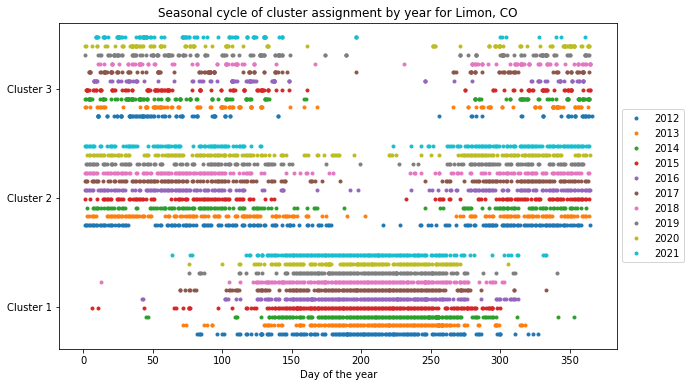

In [ ]:
## seasonal cluster assignment by day of year for Limon, CO
#seasonal_assignment_by_year("Limon, CO", cluster_label_list, FOUR_CLUSTERS, limonClusterDF, limonIdx4)
seasonal_assignment_by_year("Limon, CO", cluster_label_list, THREE_CLUSTERS, limonClusterDF, limonIdx3)

In [ ]:
## 4 season model number of days assigned to each season vs meteorological seasons
#hist_type_1(limonIdx4, limonSeasonIdx, FOUR_CLUSTERS, cluster_label_list[0:4])

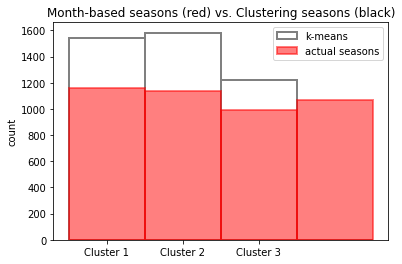

In [ ]:
# 3 season model number of days assigned to each season vs. meteorological seasons
hist_type_1(limonIdx3, limonSeasonIdx, THREE_CLUSTERS, cluster_label_list[0:3])

Temperature and Relative Humidity Scatterplots for 3 Clusters (optionally 4)

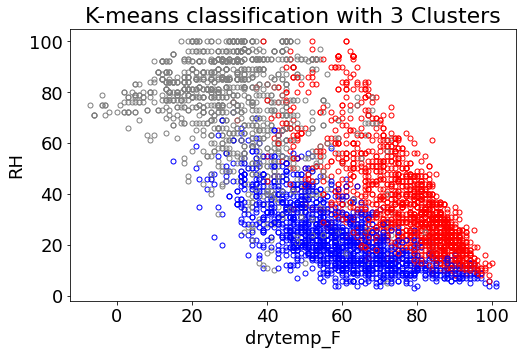

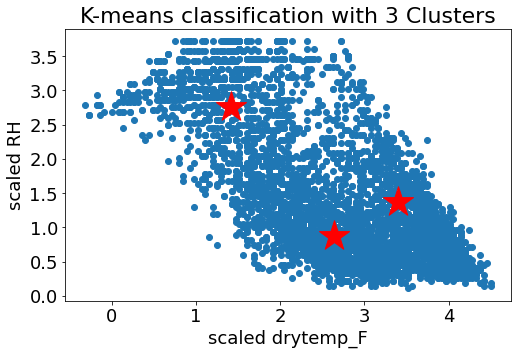

In [ ]:
## Limon scatterplots air temperature vs. relative humidity
#variable_scatter_plots(limonScaledData, "drytemp_F", "RH", included_cols, FOUR_CLUSTERS, limonIdx4, limonCentroids4, limonData)
variable_scatter_plots(limonScaledData, "drytemp_F", "RH", included_cols, THREE_CLUSTERS, limonIdx3, limonCentroids3, limonData)

Temperature and Wind Speed Scatterplots for 3 Clusters (optionally 4)

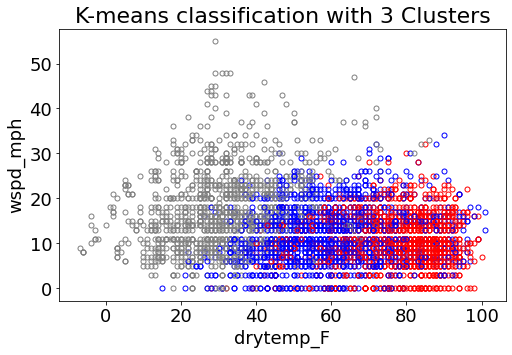

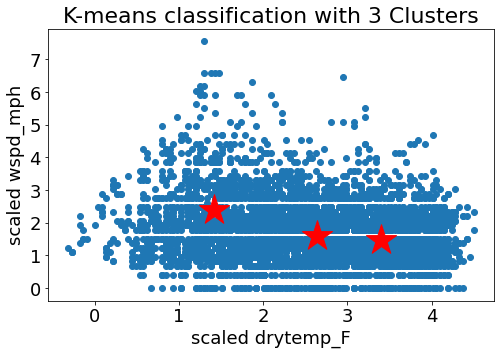

In [ ]:
## scatterplots for air temperature and wind speed
#variable_scatter_plots(limonScaledData, "drytemp_F", "wspd_mph", included_cols, FOUR_CLUSTERS, limonIdx4, limonCentroids4, limonData)
variable_scatter_plots(limonScaledData, "drytemp_F", "wspd_mph", included_cols, THREE_CLUSTERS, limonIdx3, limonCentroids3, limonData)

Wind Speed and Relative Humidity Scatterplots for 3 Clusters

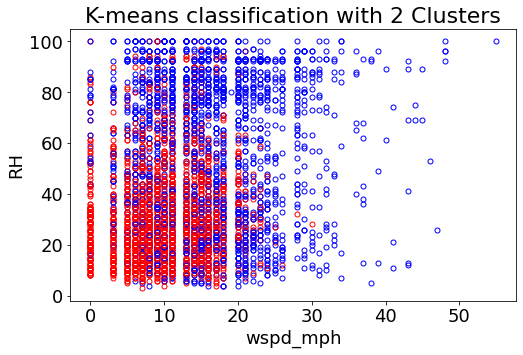

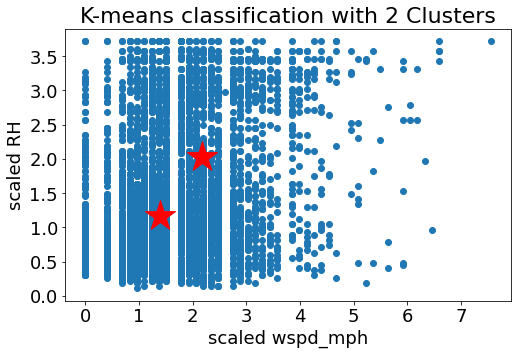

In [ ]:
## scatterplot for wind speed and relative humidity
variable_scatter_plots(limonScaledData, "wspd_mph","RH", included_cols, TWO_CLUSTERS, limonIdx2, limonCentroids2, limonData)

#### Plots for Boulder, CO

Please note: there are many graphs commented out. These graphs may be uncommented back into the code and run for comparison purposes. The graphs that remain uncommented are the best clustering fit for Boulder, CO and thus are the ones shown. 

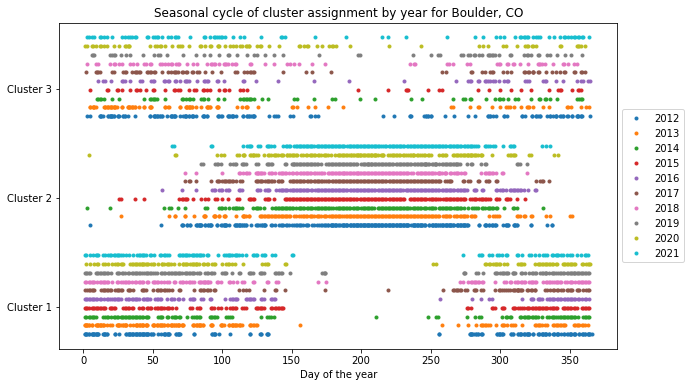

In [ ]:
#seasonal_assignment_by_year("Boulder, CO", cluster_label_list, FOUR_CLUSTERS, boulderClusterDF, boulderIdx4)
seasonal_assignment_by_year("Boulder, CO", cluster_label_list, THREE_CLUSTERS, boulderClusterDF, boulderIdx3)

In [ ]:
#hist_type_1(boulderIdx4, boulderSeasonIdx, FOUR_CLUSTERS, cluster_label_list[0:4])

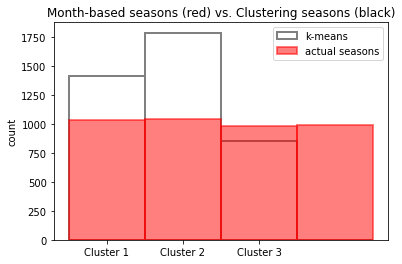

In [ ]:
hist_type_1(boulderIdx3, boulderSeasonIdx, THREE_CLUSTERS, cluster_label_list[0:3])

Air temperature and Relative Humidity Scatterplots for 3 Clusters (optionally 4)

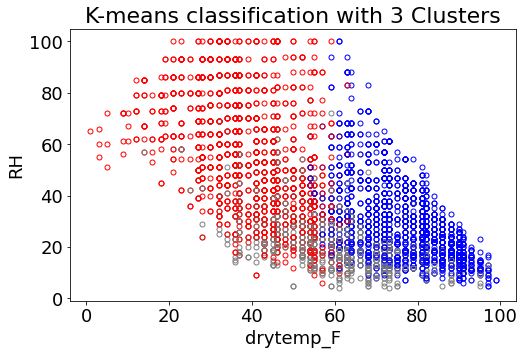

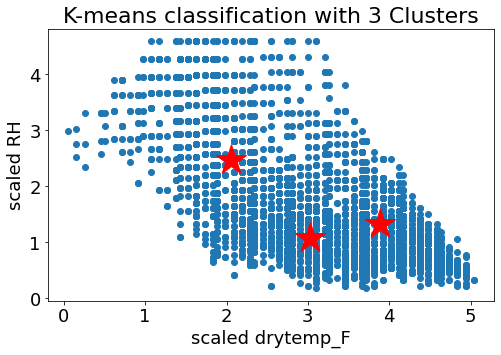

In [ ]:
## air temperature vs. relative humidity scatterlots
#variable_scatter_plots(boulderScaledData, "drytemp_F", "RH", included_cols, FOUR_CLUSTERS, boulderIdx4, boulderCentroids4, boulderData)
variable_scatter_plots(boulderScaledData, "drytemp_F", "RH", included_cols, THREE_CLUSTERS, boulderIdx3, boulderCentroids3, boulderData)

Temperature and Wind Speed Scatterplots for 3 Clusters (optionally 4)

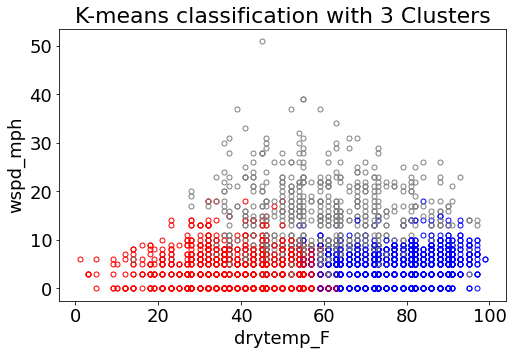

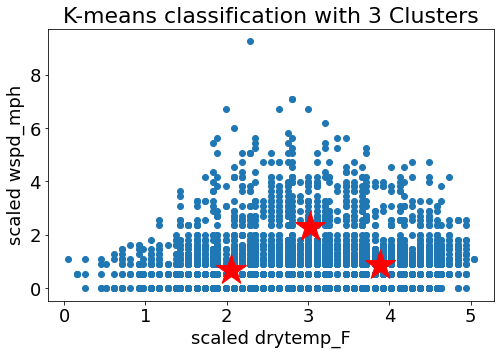

In [ ]:
#variable_scatter_plots(boulderScaledData, "drytemp_F", "wspd_mph", included_cols, FOUR_CLUSTERS, boulderIdx4, boulderCentroids4, boulderData)
variable_scatter_plots(boulderScaledData, "drytemp_F", "wspd_mph", included_cols, THREE_CLUSTERS, boulderIdx3, boulderCentroids3, boulderData)

#### Plots for Eagle, CO
Please note: there are many graphs commented out. These graphs may be uncommented back into the code and run for comparison purposes. The graphs that remain uncommented are the best clustering fit for Eagle, CO and thus are the ones shown. 

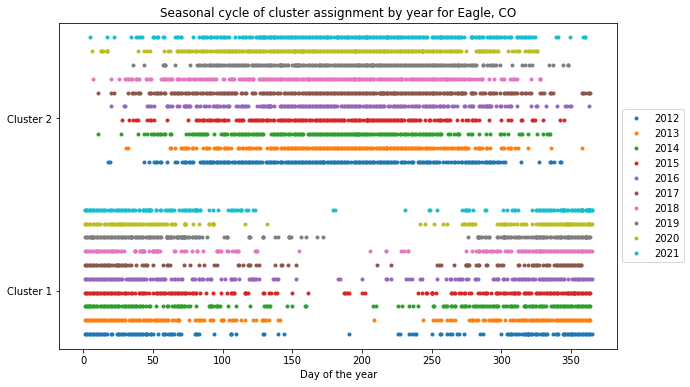

In [ ]:
## Code commented out may be ran for comparison against the 2 cluster graph, but 2 clusters fits best for this location (Eagle CO).
#seasonal_assignment_by_year("Eagle, CO", cluster_label_list, FOUR_CLUSTERS, eagleClusterDF, eagleIdx4)
#seasonal_assignment_by_year("Eagle, CO", cluster_label_list, THREE_CLUSTERS, eagleClusterDF, eagleIdx3)
seasonal_assignment_by_year("Eagle, CO", cluster_label_list, TWO_CLUSTERS, eagleClusterDF, eagleIdx2)

In [ ]:
#hist_type_1(eagleIdx4, eagleSeasonIdx, FOUR_CLUSTERS, cluster_label_list[0:4])

In [ ]:
#hist_type_1(eagleIdx3, eagleSeasonIdx, THREE_CLUSTERS, cluster_label_list[0:3])

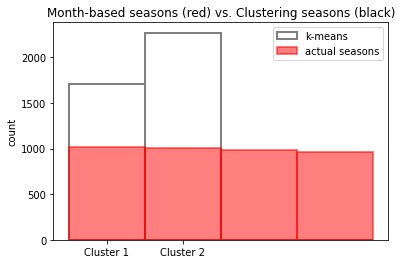

In [ ]:
hist_type_1(eagleIdx2, eagleSeasonIdx, TWO_CLUSTERS, cluster_label_list[0:2])

Air temperature and Relative Humidity for 2 Clusters (optionallys 3)

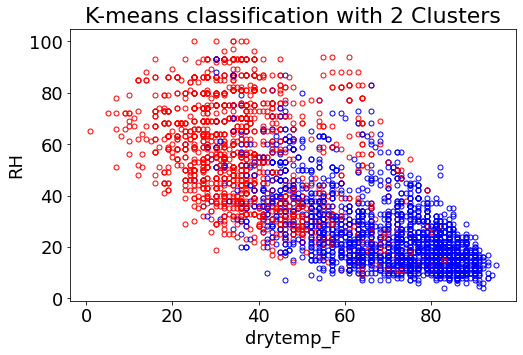

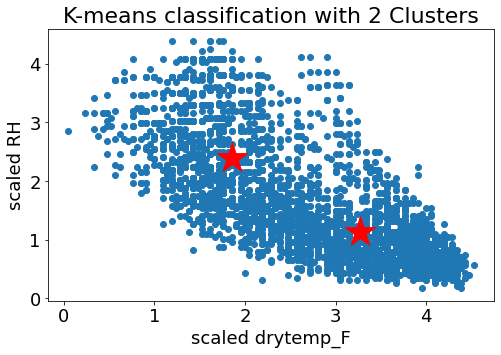

In [ ]:
#variable_scatter_plots(eagleScaledData, "drytemp_F","RH", included_cols, THREE_CLUSTERS, eagleIdx3, eagleCentroids3, eagleData)
variable_scatter_plots(eagleScaledData, "drytemp_F","RH", included_cols, TWO_CLUSTERS, eagleIdx2, eagleCentroid2, eagleData)

Temperature and Wind Speed for 2 Clusters (optionally 3)

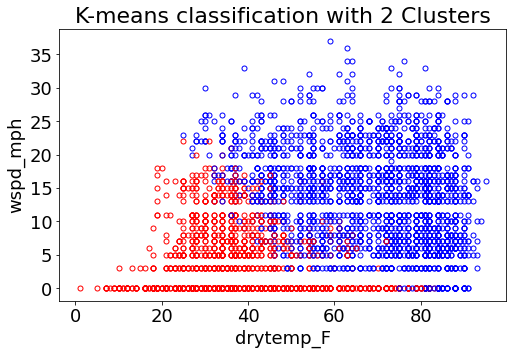

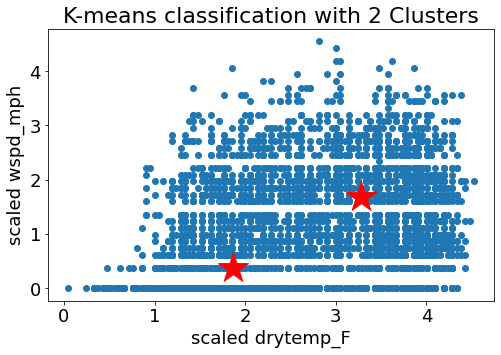

In [ ]:
#variable_scatter_plots(eagleScaledData, "drytemp_F","wspd_mph", included_cols, THREE_CLUSTERS, eagleIdx3, eagleCentroids3, eagleData)
variable_scatter_plots(eagleScaledData, "drytemp_F","wspd_mph", included_cols, TWO_CLUSTERS, eagleIdx2, eagleCentroid2, eagleData)

Wind Speed and Relative Humidity for 2 Clusters (optionally 3)


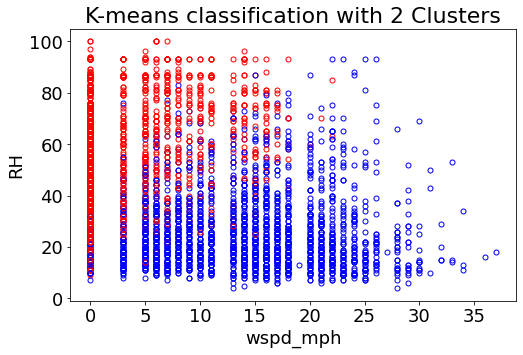

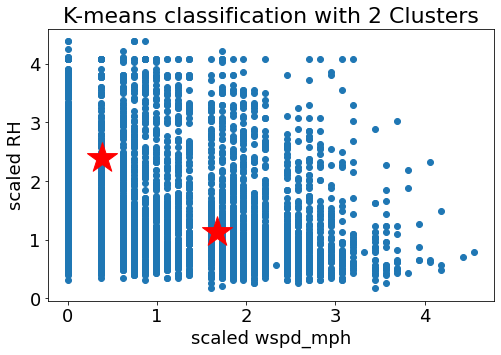

In [ ]:
#variable_scatter_plots(eagleScaledData, "wspd_mph","RH", included_cols, THREE_CLUSTERS, eagleIdx3, eagleCentroids3, eagleData)
variable_scatter_plots(eagleScaledData, "wspd_mph","RH", included_cols, TWO_CLUSTERS, eagleIdx2, eagleCentroid2, eagleData)

#### Plots for Grand Junction, CO
Please note: there are many graphs commented out. These graphs may be uncommented back into the code and run for comparison purposes. The graphs that remain uncommented are the best clustering fit for Grand Junction, CO and thus are the ones shown. 

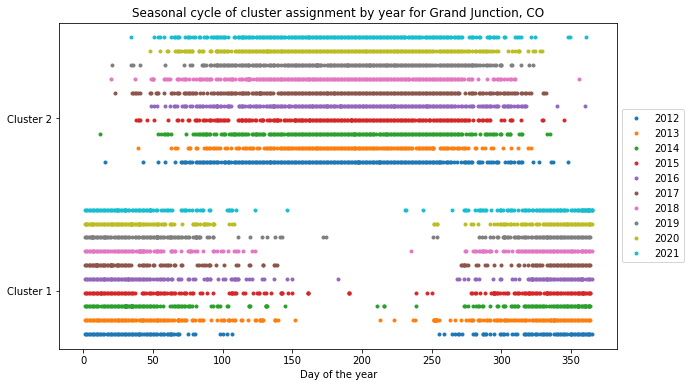

In [ ]:
#seasonal_assignment_by_year("Grand Junction, CO", cluster_label_list, FOUR_CLUSTERS, grandJunctionClusterDF, grandJunctionIdx4)
#seasonal_assignment_by_year("Grand Junction, CO", cluster_label_list, THREE_CLUSTERS, grandJunctionClusterDF, grandJunctionIdx3)
seasonal_assignment_by_year("Grand Junction, CO", cluster_label_list, TWO_CLUSTERS, grandJunctionClusterDF, grandJunctionIdx2)

In [ ]:
#hist_type_1(grandJunctionIdx4, grandJunctionSeasonIdx, FOUR_CLUSTERS, cluster_label_list[0:4])

In [ ]:
#hist_type_1(grandJunctionIdx3, grandJunctionSeasonIdx, THREE_CLUSTERS, cluster_label_list[0:3])

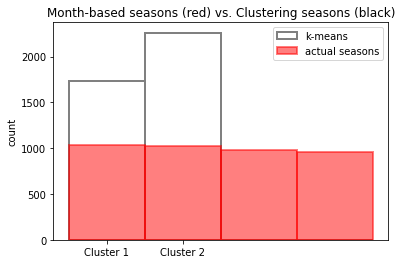

In [ ]:
hist_type_1(grandJunctionIdx2, grandJunctionSeasonIdx, TWO_CLUSTERS, cluster_label_list[0:2])

Air temperature and Relative Humidity for 2 Clusters

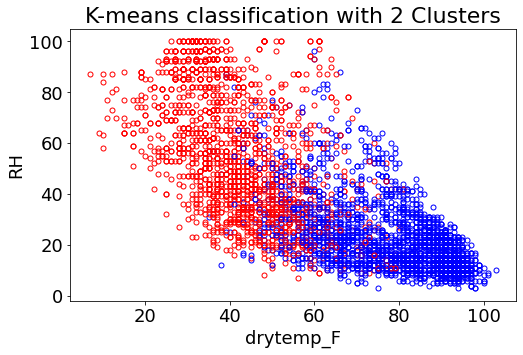

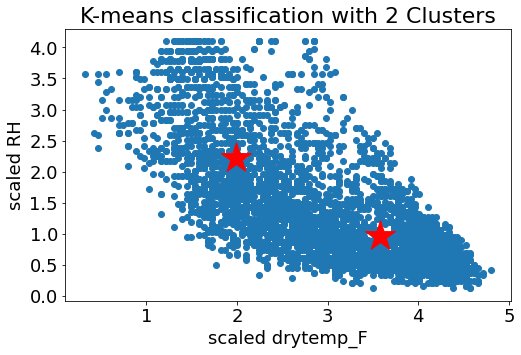

In [ ]:
variable_scatter_plots(grandJunctionScaledData, "drytemp_F","RH", included_cols, TWO_CLUSTERS, grandJunctionIdx2, grandJunctionCentroids2, grandJunctionData)

Temperature and Wind Speed for 2 Clusters

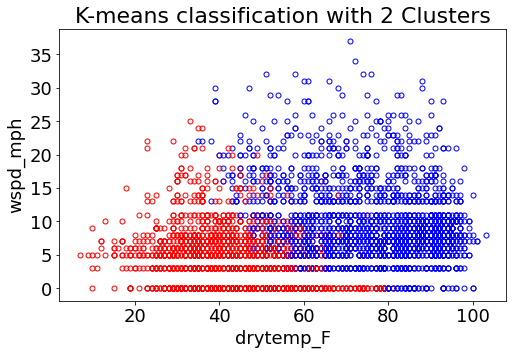

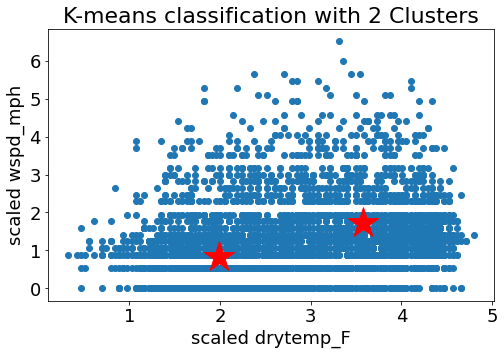

In [ ]:
variable_scatter_plots(grandJunctionScaledData, "drytemp_F","wspd_mph", included_cols, TWO_CLUSTERS, grandJunctionIdx2, grandJunctionCentroids2, grandJunctionData)

Wind Speed and Relative Humidity for 3 and 2 Clusters

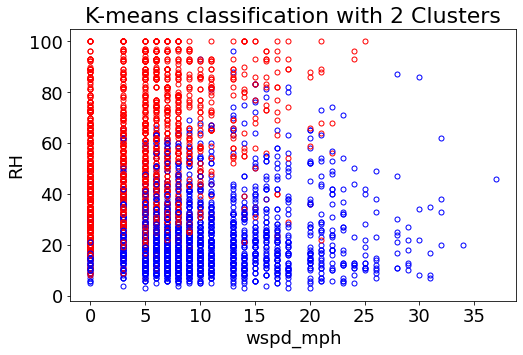

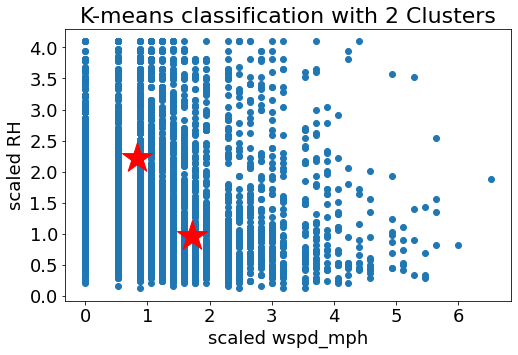

In [ ]:
#variable_scatter_plots(grandJunctionScaledData, "wspd_mph","RH", included_cols, THREE_CLUSTERS, grandJunctionIdx3, grandJunctionCentroids3, grandJunctionData)
variable_scatter_plots(grandJunctionScaledData, "wspd_mph","RH", included_cols, TWO_CLUSTERS, grandJunctionIdx2, grandJunctionCentroids2, grandJunctionData)

###**Summary**

#### **Limon, CO**
The traditional 4 season model does not seem to be a good fit for Limon, CO. The best fit for this location is a three season model with summer, winter, and transition seasons. From the seasonal cluster assignment by year plots, the overlap between clusters 1 and 3, and to some extent 2, show that the 4 season model is not an appropriate fit for this location. This notion is supported by the bar plots of month-based seasons and clustered seasons, since there were far more days allocated to clusters 2 and 4 than there are days in those seasons traditionally, and cluster 3 had far fewer days allocated than it should have if the climate of Limon truly fit a 4 season model. The 3 season model was much more balanced in the number of days assigned to each cluster.

The variable scatterplots for air temperature vs. relative humidity support a 3 season model being the best fit for Limon, since the datapoints assigned to each cluster had more overlap for the 4 season model than the 3. One of the clusters actually only existed within the bounds of the other 3 clusters, there weren't any condidtions where it was the dominant season. The seasons as defined by the 3 season model also seemed to be appropriate. The characteristics of the three seasons were cold and wet, warm and dry, and hot and (primarily) dry.

The wind speed vs. air temperature scatterplots had a more compelling case for 4 seasons than the air temperature vs. relative humidity plots, since the centroids were well spaced for 4 seasons and the individual datapoints had only a small amount of overlap. However, one of the clusters was made up of days that had strong wind speed at *any* temperature, which did not seem appropriate to define a season based on that characteristic. 

A 2 season model- summer and winter- was also analyzed. This model was determined to be an insufficient fit for Limon. The only plot that showed a better fit for a 2 season model was the relative humidity vs. wind speed scatterplot, which did not have 3 well defined groups when plotted for a 3 season model. Since these two variables paired together was the only plot that supported a 2 season model, it was determined to be a poor fit for Limon, CO, which opposes the hypothesis that locations far from major topographic features, like the Rocky Mountains, will be best represented by a 2 season model.

#### **Boulder, CO**

Similar to Limon, the more traditional 4 season model does not adequately represent the climate in boulder. The seasonal cluster assignment by year plot for 4 clusters results in clusters 1, 2 and 3 encompassing much of the fall, winter, and spring dates, while the dates contributing to cluster 4 only fall within the late spring, summer, and early fall. Cluster 3 does exclude more days from the summer months than 1 and 2, which leads to the assumption that cluster 3 represents winter-like conditions. Clusters 1 and 2 are so similar in this plot that it seems redundant to have two clusters representing these dates.

The 3 season model for for the assignment by year plot has more distinct seasons than the 4 season model. Cluster 2 clearly represents summer-like days, cluster 3 is winter-like conditions, and cluster 1 is a transitional season.

The barplots of month-based seasons and clustered seasons for the 4 and 3 season models tell a similar narrative as the date-based plot. Cluster 2 in the four season model has around 2/3 of the days assigned as it should based on the metworological season. This indicates that the characteristics that define cluster 2 do not apply to enough days to warrant its own season.

The 3 season plot is still fairly unbalanced, with cluster 1 retaining about 700 days less than the next smallest cluster. Cluster 1 does represent the transitional season though, and fewer transitional days than winter or summer days is expected. The difference in the number of days assigned to clusters 2 and 3 is an indication that summer-like conditions are more common in Boulder than winter conditions, and not that 3 the 3 season model is a poor fit for this location.

The scatterplots of air temperature and relative humidity, as well as the air temperature and wind speed support a 3 season model for Boulder over a 4 season model. The 4 season model plots for both the wind speed and relative humidity vs. temperature have significant overlap between the clusters, most notably in the air temperature vs. relative humidity plot for the clusters identified by the blue and grey markers. The distance between the centroids for these two clusters is much smaller than for any other centroid pair, whic is an indication that the data cannot support the number of clusters specified. In contrast, the 3 cluster model for these plots have evenly spaced centroids and minimal overlap between the clusters. From these scatterplots, characteristics for the 3 seasons present for Boulder, CO are determined as:
- Winter: cold, humid, and calm
- Summer: hot, variable humidity, and calm
- Transition: warm, dry, and windy

The 3 season model is the best fit for Boulder, CO, which is in line with the hypothesis that locations closer to major topographic features will be best represented by a 3 season model.

#### **Eagle, CO**
The 4 season model does not correspond well to the weather experienced in Eagle, CO. Instead, a two season model, summer and winter, fits best here. This is supported by the lack of apparent clustering in two seasons of the four season assignment by year graph, as well as the lack of clustering in one season when this graph was created with three seasons. The two season assignment by year plot is the one with the strongest clustering, this trend continues throughout the rest of the plots created with Eagle data. 

The air temperature vs. relative humidity variable scatterplot also supports that 2 clusters is the best fit for Eagle. There is a 3 cluster graph along with the 2 cluster scatterplot to demonstrate the lack of fit for anything more than 2 clusters. With the 3 cluster graph, one cluster is spread through out the other 2, making it apparent that it is not clearly defined. The 2 cluster plot removes this issue and creates a more clearly defined relationship between temperature and RH. It seems typical that with a high RH, there is a low temperature and with a high temp there is low RH. 

The scatterplots for temperature vs. wind speed also show 3 and 2 clusters. As with the previous variables, 3 clusters is too many, with one cluster that covered the entire range of temperatures at one wind speed. Decreasing the clustering to 2 clusters fixed this issue and created more defined conditions particularly high wind speeds were only reached on days with high temp. 

The wind speed vs. relative humidity scatterplots also demonstrate that 2 clusters fit best with Eagle. The 3 cluster scatterplot has a cluster around a wind speed of 0, covering all levels of RH. Moving down to 2 clusters removes this issue and shows a stronger relationship between the variables with high RH occuring alongside lower wind speeds and a more broad range of RH occuring with  higher windspeeds. 

Overall, Eagle is best represented by 2 seasons, winter and summer. This does not fit with our original hypothesis that locations near major topographical feature will experience 3 seasons, winter, summer, and a transition season.  


#### **Grand Junction, CO**
The traditionally defined four seasons do not seem to correlate strongly with the weather in Grand Junction, CO. This is supported by the seasonal by year graphs, which show two significant clusters, and two scattered in the four season assignment. When you adjust to two, the data clearly clusters, indicating that two seasons is the best fit for Grand Junction. 

The scatterplot comparing temperature vs. relative humidity also supports the hypothesis that 2 clusters best fit the Grand Junction dataset. The scatterplot shows a cluster of low temperature and higher relative humidities, and high temps with lower RHs.

The temperature vs. wind speed scatterplots are also correlated the strongest when 2 clusters are used. In Grand Junction there does not seem to be a strong relationship between these variables, as a range of similar wind speeds fit the clusters for high and low temperatures. There is a slightly higher range of wind speeds with higher temperatures, and some slower wind speeds with low temperatures. 2 clusters is still most relevant here.

The scatterplot depicting wind speed vs. relative humidity with 2 clusters is the most appropriate fit for the data. When 3 clusters are used, there is a cluster that occurs largely at a wind speed of 0 mph, that spans all relative humidities. When that cluster is eliminated and 2 clusters are used to plot these variables, there is a stronger relationship between them. In general, it appears that higher RH is related to lower wind speed, and lower RH relates to higher wind speed. That being said, the relationship between variables is not incredibly distinct. 

Overall, Grand Junction supported our original hypothesis, as the data from this location fit best with 2 clusters. We hypothesized that more remote locations, further from significant topographic changes, would have two distinct seasons, fitting winter and summer weather. 


#### **Do locations at similar distance from major topography have similar seasonality?**

Limon, CO: 3 seasons
Boulder, CO: 3 seasons
Eagle, CO: 2
Grand Junction, CO: 2

if Grand Junction and Limon have similar seasonality, and Boulder and Eagle have similar seasonality, the hypothesis is confirmed.

Our hypothesis was not confirmed, as the data from Limon fit more appropriately with three seasons, and the data from Grand Junction fit better with two seasons. Our hypothesis also failed for the data from Boulder and Eagle, with Boulder fitting three seasons the best, and Eagle fitting two seasons best. Instead of topographic change being related to seasonality, it may be that the longitudinal location is a stronger determinant for the number of seasons experienced at a given location in Colorado.



#### **Response to Reviewer:**


### References

1. National Centers for Environmental Information (2010). Local Climatological Data (LCD) from Boulder Municipal Airport, CO US [Dataset]. Climate Data Online. https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:00160/detail(retrieved 4-05-2022).

2. National Centers for Environmental Information (1948). Local Climatological Data (LCD) from Eagle CO Airport, CO US [Dataset]. Climate Data Online. https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:23063/detail (retrieved 4-05-2022)

3. National Centers for Environmental Information (1948). Local Climatological Data (LCD) from Grand Junction Walker Field, CO US [Dataset]. Climate Data Online. https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:23066/detail (retrieved 4-05-2022)

4. National Centers for Environmental Information (1973). Local Climatological Data (LCD) from Limon, CO US [Dataset]. Climate Data Online. https://www.ncdc.noaa.gov/cdo-web/datasets/LCD/stations/WBAN:93010/detail (retrieved 4-05-2022)